In [1]:
from torch.nn.parameter import Parameter, UninitializedParameter
import torch
from torch import nn
from torch import Tensor
from torch.nn import init
import math
from math import gcd
from math import sqrt
from torch.nn import functional as F


class PHMLayer(nn.Module):

  def __init__(self, in_features, out_features,n=2):
    super(PHMLayer, self).__init__()
    self.n = n
    self.in_features = in_features
    self.out_features = out_features

    self.bias = Parameter(torch.Tensor(out_features))

    self.a = torch.zeros((n, n, n))
    self.a = Parameter(torch.nn.init.xavier_uniform_(self.a))

    self.s = torch.zeros((n, self.out_features//n, self.in_features//n)) 
    self.s = Parameter(torch.nn.init.xavier_uniform_(self.s))

    self.weight = torch.zeros((self.out_features, self.in_features))

    fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

  def kronecker_product1(self, a, b):

    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    out = res.reshape(siz0 + siz1)

    return out

  def forward(self, input: Tensor) -> Tensor:
    self.weight = torch.sum(self.kronecker_product1(self.a, self.s), dim=0)

    input = input.type(dtype=self.weight.type())

      
    return F.linear(input, weight=self.weight, bias=self.bias)

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
      self.in_features, self.out_features, self.bias is not None)
    
  def reset_parameters(self) -> None:
    init.kaiming_uniform_(self.a, a=math.sqrt(5))
    init.kaiming_uniform_(self.s, a=math.sqrt(5))
    fan_in, _ = init._calculate_fan_in_and_fan_out(self.placeholder)
    bound = 1 / math.sqrt(fan_in)
    init.uniform_(self.bias, -bound, bound)

In [2]:
from torch import nn
from transformers import RobertaTokenizer
from transformers import RobertaModel
class Model_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, dropout):
        super(Model_Classifier, self).__init__()
        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-large')
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        self.dropout = dropout
        self.linear = nn.Linear(self.embedding_dim, self.hidden_dim)
        self.Drop = nn.Dropout(self.dropout)
        self.linear2 = nn.Linear(self.hidden_dim, self.num_labels)
        
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            # nn.Dropout(self.dropout),
            #nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, self.num_labels)
        )

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0]

        last_hidden_state_cls = self.linear(last_hidden_state_cls)

        last_hidden_state_cls = self.Drop(last_hidden_state_cls)
        

        logits = self.linear2(last_hidden_state_cls)[:, 0, :]

        #logits = self.classifier(last_hidden_state_cls)

        return logits, last_hidden_state_cls,outputs[0]
class QModel_Classifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, dropout,feature_remove_max= True):
        super(QModel_Classifier, self).__init__()
        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-large')
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_labels = num_labels
        self.dropout = dropout

        
        divisors = sorted(self.cf(embedding_dim,hidden_dim))
        divisors1 = sorted(self.cf(hidden_dim,num_labels))
        common_divisors = sorted(set(divisors1) & set(divisors))
        if(feature_remove_max == True):
            self.n = common_divisors[-1]
        else :
            self.n = common_divisors[0]
        
        self.linear = PHMLayer(self.embedding_dim, self.hidden_dim,self.n)
        self.Drop = nn.Dropout(self.dropout)
        self.linear2 = PHMLayer(self.hidden_dim, self.num_labels,self.n)
        

    def cf(self,num1,num2):
            n=[]
            g=gcd(num1, num2)
            for i in range(1, int(sqrt(g))+1):
                if g%i==0:
                    n.append(i)
                    if g!=i*i:
                        n.append(int(g/i))
            return n

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task

        last_hidden_state_cls = outputs[0]
        #print(last_hidden_state_cls.shape)
        last_hidden_state_cls = self.linear(last_hidden_state_cls)
        #print(last_hidden_state_cls.shape)
        last_hidden_state_cls = self.Drop(last_hidden_state_cls)
        #print(last_hidden_state_cls.shape)

        logits = self.linear2(last_hidden_state_cls)[:, 0, :]
        #print(logits.shape)
        # Feed input to classifier to compute logits
        #logits = self.classifier(last_hidden_state_cls)
        
        return logits, last_hidden_state_cls,outputs[0]

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import libraries
import csv
import random
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
import torch
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn, optim, tensor
from transformers import RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)

def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    # torch.cuda.manual_seed_all(seed_value)


# set parameters
SEED = 40
MAX_LEN = 40
epoch =1 # number of epochs
num_train = 100  # number of training samples
num_classes = 2  # number of classes
num_val = 500  # number of validation samples
scl = True  # if True -> scl + cross entropy loss. else just cross entropy loss
temprature = 0.3  # temprature for contrastive loss
lam = 0.9  # lambda for loss


#stas
#train_path = "stas/train.tsv"
#valid_path = "stas/dev.tsv"
#test_path = "stas/test.tsv"

#med24k
#train_path = "PubMed20K/train.csv"
#valid_path = "PubMed20K/val.csv"
#test_path = "PubMed20K/test.csv"

#trec
# upside down augmentation included
train_path = "trec/train.tsv"
valid_path = "trec/dev.tsv"
test_path = 'trec/test.tsv'


aug_path = 'trec_aug/gpt2_eda.tsv'

#snips
#train_path ='snips/train.csv'
#valid_path = 'snips/dev.csv'
#test_path = 'snips/test.csv'


tsv = False
if(train_path[-3:]=='tsv'):
    tsv = True




scl_model_path = r"trecscl_model.pt"
cross_model_path = r"treccross_model.pt"


# a function for preprocessing text
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, MAX_LEN):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=True  # Return attention mask
        )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks



# preparing data
def prepare_data(num_train, train_path, valid_path , test_path = None, aug_path = None,sample = 10 , seed = 32, tsv = False , all=True , aug = False):
    # load data
    # for tsv
    if(tsv == True) : 
        
        train_ds = pd.read_csv(train_path, sep='\t',quoting=csv.QUOTE_NONE)
        val_ds = pd.read_csv(valid_path, sep='\t',quoting=csv.QUOTE_NONE)
    else:
        train_ds = pd.read_csv(train_path,quoting=csv.QUOTE_NONE)
        val_ds = pd.read_csv(valid_path,quoting=csv.QUOTE_NONE)
        
    global num_classes
    num_classes = len(train_ds['label'].unique())
    
    #original one
    if(all == False):
        train_df = [train_ds.loc[train_ds.label == i].sample(n=sample, random_state=seed) for i in
                    train_ds.label.unique()]
        train_df = pd.concat(train_df, axis=0)
    else :
        #for augmentation data
        train_df = train_ds
    
    train_df = train_df[['sentence','label']]
    print(train_df.head(3))
    # data augmentation 
    if(aug == True):
        indexs = train_df.index.values.tolist()
        aug_ds =   pd.read_csv(aug_path, sep='\t',quoting=csv.QUOTE_NONE)
        aug_df = [aug_ds[i*6:i*6+6] for i in
                            indexs]
        print(aug_df[:3])
        
        aug_df = pd.concat(aug_df, axis=0).sample(frac=1)
        
        train_df = pd.concat([train_df,aug_df], axis=0).sample(frac=1).reset_index(drop=True)
    


   # combine with aug data
    #combine_df = pd.concat([train_df, aug_df], axis=0)
    #combine_df = combine_df.reset_index() 

    if((test_path == None)):
        val_df = val_ds[:num_val]
        test_df = val_ds[int(len(val_ds) / 2):].reset_index(drop=True)
    elif((test_path != None) and (tsv==True)):
        val_df = val_ds
        test_df = pd.read_csv(test_path, sep='\t')
    else:
        test_df = pd.read_csv(test_path)
        val_df = val_ds


    sample = 10

    # random 20 per class sample for validation
    val_df = [val_df.loc[val_df.label == i].sample(n=sample, random_state=seed,replace=True) for i in
                    val_df.label.unique()]
    val_df = pd.concat(val_df, axis=0, ignore_index=True).sample(frac=1)

    
    train_text = train_df["sentence"].tolist()
    train_label = train_df["label"].tolist()
    val_text = val_df["sentence"].tolist()
    val_label = val_df["label"].tolist()
    test_text = test_df["sentence"].tolist()
    test_label = test_df["label"].tolist()

    # Concatenate train data and test data
    all_text = np.concatenate([train_text, val_text], axis=0)

    # Encode our concatenated data
    encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_text]
    global MAX_LEN
    # Find the maximum length
    MAX_LEN = max([len(sent) for sent in encoded_text])

    # preprocessing train data
    for i in range(len(train_text)):
        train_text[i] = text_preprocessing(train_text[i])

    # preprocessing validation data
    for i in range(len(val_text)):
        val_text[i] = text_preprocessing(val_text[i])

    # preprocessing test data
    for i in range(len(test_text)):
        test_text[i] = text_preprocessing(test_text[i])

    # Run function `preprocessing_for_bert` on the train set and the validation set
    # print('Tokenizing data...')
    train_inputs, train_masks = preprocessing_for_bert(train_text, MAX_LEN)
    val_inputs, val_masks = preprocessing_for_bert(val_text, MAX_LEN)
    test_inputs, test_masks = preprocessing_for_bert(test_text, MAX_LEN)

    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(train_label)
    val_labels = torch.tensor(val_label)
    test_labels = torch.tensor(test_label)

    # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
    batch_size = 64

    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for our validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # Create the DataLoader for our test set
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    


def initialize_model(model,hidden = 16 , num_labels = 2 ,feature_remove_max=True):
    """Initialize the Classifier, the optimizer and the learning rate scheduler.
    """

    # Instantiate Bert Classifier
    if(model == QModel_Classifier):
        model_classifier = model(1024, hidden_dim=hidden, num_labels = num_labels, dropout=0.1,feature_remove_max=feature_remove_max)
    else:
        model_classifier = model(1024, hidden_dim=hidden, num_labels = num_labels, dropout=0.1)

    # Tell PyTorch to run the model on GPU
    model_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(model_classifier.parameters(),
                      lr=4e-5,  # Default learning rate
                      eps=1e-8  # Default epsilon value
                      )

    return model_classifier, optimizer


def contrastive_loss(temp, embedding, label):
    """calculate the contrastive loss
    """
    nsamples, nx, ny = embedding.shape
    embedding = embedding.reshape((nsamples,nx*ny))
    
    # cosine similarity between embeddings
    cosine_sim = cosine_similarity(embedding, embedding)
    # remove diagonal elements from matrix
    dis = cosine_sim[~np.eye(cosine_sim.shape[0], dtype=bool)].reshape(cosine_sim.shape[0], -1)
    # apply temprature to elements
    dis = dis / temp
    cosine_sim = cosine_sim / temp
    # apply exp to elements
    dis = np.exp(dis)
    cosine_sim = np.exp(cosine_sim)

    # calculate row sum
    row_sum = []
    for i in range(len(embedding)):
        row_sum.append(sum(dis[i]))
    # calculate outer sum
    contrastive_loss = 0
    for i in range(len(embedding)):
        n_i = label.tolist().count(label[i]) - 1
        inner_sum = 0
        # calculate inner sum
        for j in range(len(embedding)):
            if label[i] == label[j] and i != j:
                inner_sum = inner_sum + np.log(cosine_sim[i][j] / row_sum[i])
        if n_i != 0:
            contrastive_loss += (inner_sum / (-n_i))
        else:
            contrastive_loss += 0
    return contrastive_loss


def evaluate(model, val_dataloader, tem, lam, scl):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    loss_fn = nn.CrossEntropyLoss()
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits, h_s,_ = model(b_input_ids, b_attn_mask)

        # Compute loss
        if scl:
            cross_loss = loss_fn(logits, b_labels)
            contrastive_l = contrastive_loss(tem, h_s.cpu().detach().numpy(), b_labels)
            loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)
            val_loss.append(loss.item())
        else:
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            #self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



def train(model, train_dataloader, tem, lam, scl,epoch = 40,val_dataloader=None, evaluation=False,patience = 25):
    """Train the BertClassifier model.
    """
    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()
    # Start training loop
    print("Start training...\n")
    val_list = []
    train_list = []
    best_validation_loss = float('inf')
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    for e in range(epoch):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        e = e + 1
        print(
            f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Accuracy':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-" * 86)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        train_accuracy = []
        for step, batch in enumerate(train_dataloader):
            batch_counts += 1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits, hiden_state,_ = model(b_input_ids, b_attn_mask)

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accuracy.append(accuracy)

            # Compute loss
            if scl == True:
                cross_loss = loss_fn(logits, b_labels)
                contrastive_l = contrastive_loss(tem, hiden_state.cpu().detach().numpy(), b_labels)
                loss = (lam * contrastive_l) + (1 - lam) * (cross_loss)
            if scl == False:
                loss = loss_fn(logits, b_labels)

            batch_loss += loss.item()
            total_loss += loss.item()
            print(
                f"{e:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {accuracy:^14.6} | {'-':^10} | {'-':^9} | {'-':^9.2}")

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        total_accuracy = np.mean(train_accuracy)
        train_list.append(avg_train_loss)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader, tem, lam, scl)
            val_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print("-" * 86)
            print(
                f"{'end':^7} | {'-':^7} | {avg_train_loss:^12.6f} | {total_accuracy:^14.6} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-" * 86)
        print("\n")

    
        
        if (val_loss < best_validation_loss) and scl == True:
            best_validation_loss = val_loss
            torch.save(model.state_dict(), scl_model_path)
        elif (val_loss < best_validation_loss) and scl == False:
            best_validation_loss = val_loss
            torch.save(model.state_dict(), cross_model_path)


        #early stopping
        #print(early_stopper.counter)
        if early_stopper.early_stop(val_loss):  
            break


    # plot train and valid loss
    plt.plot(list(range(len(val_list))), val_list, label="validation loss")
    plt.plot(list(range(len(train_list))), train_list, label="training loss")
    plt.title('loss')
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    print("Training complete!")

    return best_validation_loss, val_accuracy




from tqdm import tqdm
def test_evaluate(model,model_path, test_dataloader,hidden=16,num_labels=2,feature_remove_max=False):
    """After the completion of each training epoch, measure the model's performance
    on our vtest set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    if(model == QModel_Classifier):
        model = model(1024,hidden, num_labels=num_classes, dropout=0.1,feature_remove_max=feature_remove_max)
    else:
        model = model(1024,hidden, num_labels=num_classes, dropout=0.1)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Tracking variables
    test_accuracy = []
    predict = []
    y_true = []

    # For each batch in our test set...
    for batch in tqdm(test_dataloader):
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits, _ ,_= model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predict += preds.tolist()
        y_true += b_labels.tolist()

    # plot heatmap
    test_accuracy = np.mean(test_accuracy)
    cm = confusion_matrix(y_true, predict)
    plt.figure(figsize=(10, 7))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Accuracy
    print(f'Accuracy: {accuracy_score(y_true, predict)}')

    # Recall
    print(f'Recall: {recall_score(y_true, predict, average=None)}')

    # Precision
    print(f'Precision: {precision_score(y_true, predict, average=None)}')

    # F1_score
    print(f'F1_score: {f1_score(y_true, predict, average=None)}')

    return accuracy_score(y_true, predict)
    
#test_evaluate(cross_model_path, test_dataloader)
#test_evaluate(scl_model_path, test_dataloader)

# scl_test_acc = test_evaluate(scl_model_path, test_dataloader)

def model_predict(model,hidden, model_path, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model = model(1024,hidden, num_classes, dropout=0.1)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits, _,_ = model(b_input_ids, b_attn_mask)
        preds = torch.argmax(logits, dim=1).flatten()
        all_logits += preds.tolist()

    # Concatenate logits from each batch
    # all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    # probs = F.softmax(all_logits, dim=1).cpu().numpy()
    # predict = np.argmax(probs)

    return all_logits





No GPU available, using the CPU instead.


In [4]:
from kmean_cluster import *

if(tsv == False):
    df = pd.read_csv(test_path)
else:
    df = pd.read_csv(test_path,sep='\t')
ori_labels = df.label.tolist()

eda.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                                sentence
25830      5              how old was cistron siskel
25831      5               how old was factor siskel
25832      5            how sometime was gene siskel
25833      5             how onetime was gene siskel
25834      5               how older was gene siskel
25835      5  how honest to goodness was gene siskel,        label                                    sentence
25854      5       how many events work up the decathlon
25855      5       how many upshot make up the decathlon
25856      5      how many events cause up the decathlon
25857      5        how many event make up the decathlon
25858      5      how many outcome make up the decathlon
25859      5  how many consequence make up the decathlon,       l

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.784627   |    20.3125     |     -      |     -     |     -    
   1    |    1    |   1.791598   |     15.625     |     -      |     -     |     -    
   1    |    2    |   1.793610   |      12.5      |     -      |     -     |     -    
   1    |    3    |   1.794000   |     9.375      |     -      |     -     |     -    
   1    |    4    |   1.794482   |    10.9375     |     -      |     -     |     -    
   1    |    5    |   1.792693   |      25.0      |     -      |     -     |     -    
   1    |    6    |   1.792424   |    19.4444     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.792424   |    16.1706     |  1.791000  |   16.67   |  222.96  
------------------------

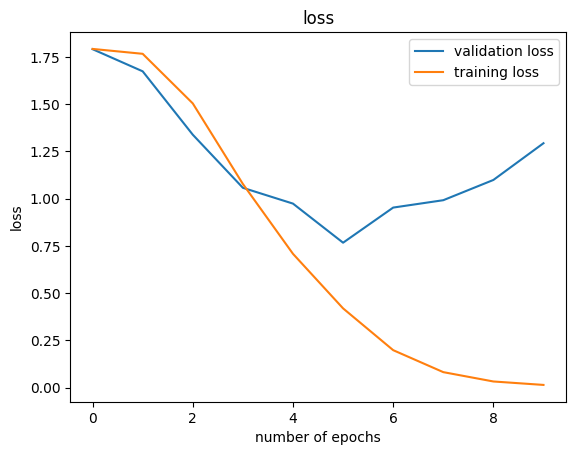

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:20<00:00,  2.53s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


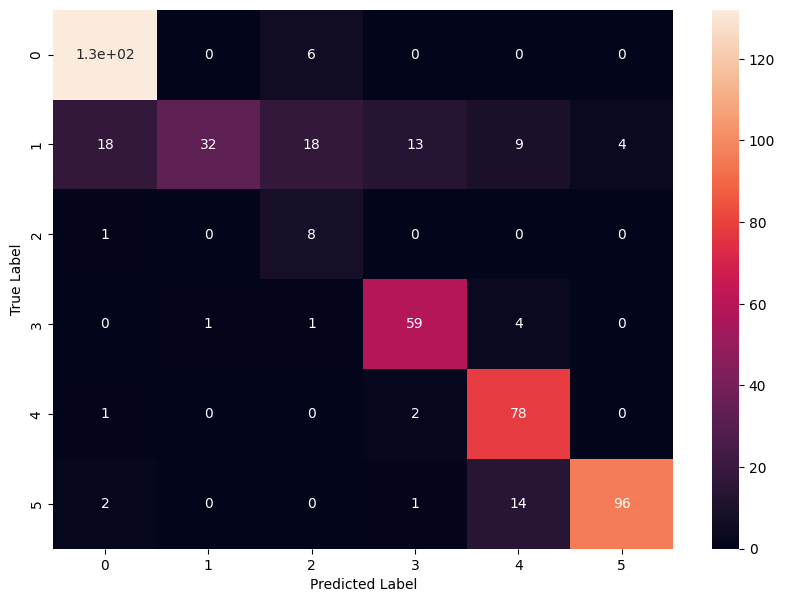

Accuracy: 0.81
Recall: [0.95652174 0.34042553 0.88888889 0.90769231 0.96296296 0.84955752]
Precision: [0.85714286 0.96969697 0.24242424 0.78666667 0.74285714 0.96      ]
F1_score: [0.90410959 0.50393701 0.38095238 0.84285714 0.83870968 0.90140845]
backtranslate.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                                   sentence
25830      5                   How old was Gene Siskel?
25831      5                 - How old was Gene Siskel?
25832      5                   How old was Gene Siskel?
25833      5                 - How old was Gene Siskel?
25834      5                 - How old was Gene Siskel?
25835      5  How many of you did the Gene Siskel have?,        label                                   sentence
25854      5     How many events make up the decathlon?
25855      5  Ho

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.798998   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.793172   |    20.3125     |     -      |     -     |     -    
   1    |    2    |   1.794040   |    14.0625     |     -      |     -     |     -    
   1    |    3    |   1.794192   |    14.0625     |     -      |     -     |     -    
   1    |    4    |   1.792370   |     21.875     |     -      |     -     |     -    
   1    |    5    |   1.791124   |     15.625     |     -      |     -     |     -    
   1    |    6    |   1.784521   |    30.5556     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.784521   |    17.9812     |  1.725914  |   33.33   |  171.71  
------------------------

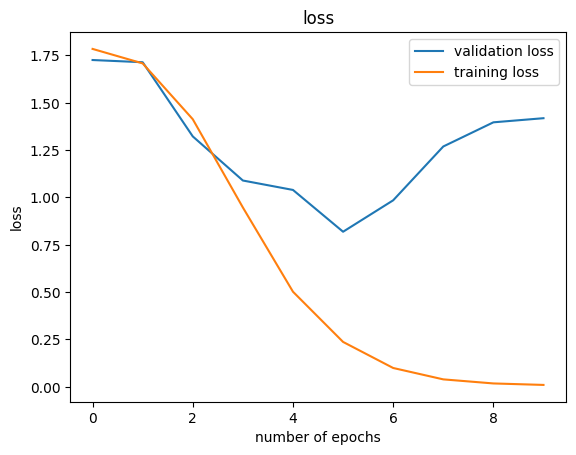

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.41s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


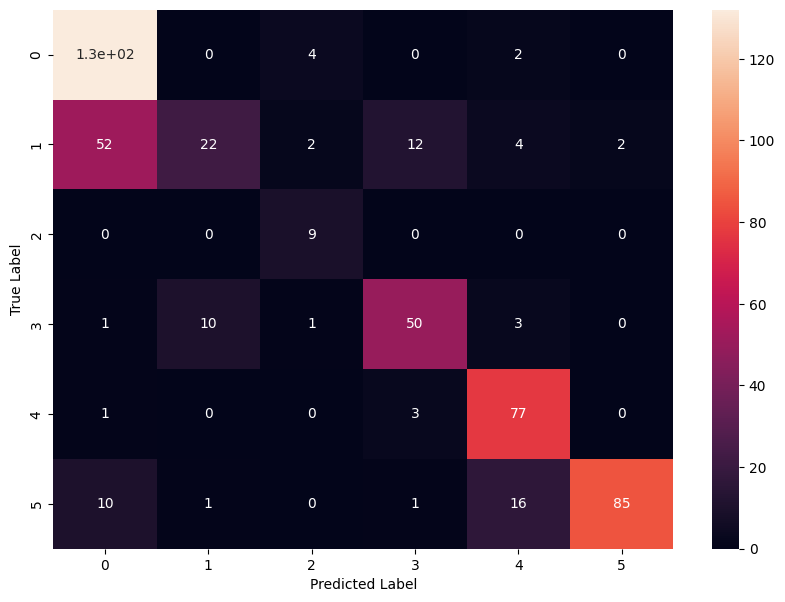

Accuracy: 0.75
Recall: [0.95652174 0.23404255 1.         0.76923077 0.95061728 0.75221239]
Precision: [0.67346939 0.66666667 0.5625     0.75757576 0.75490196 0.97701149]
F1_score: [0.79041916 0.34645669 0.72       0.76335878 0.84153005 0.85      ]
cbert.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                   sentence
25830      5  how old was gene siskel ?
25831      5  how old was gene siskel ?
25832      5  how old was gene siskel ?
25833      5  how old was gene siskel ?
25834      5  how old was gene siskel ?
25835      5  how old was gene siskel ?,        label                               sentence
25854      5  how many events make up the decathlon
25855      5  how many events make up the decathlon
25856      5  how many events make up the decathlon
25857      5  how many events make up th

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.799189   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.794355   |     18.75      |     -      |     -     |     -    
   1    |    2    |   1.794281   |    17.1875     |     -      |     -     |     -    
   1    |    3    |   1.792813   |    17.1875     |     -      |     -     |     -    
   1    |    4    |   1.792804   |     9.375      |     -      |     -     |     -    
   1    |    5    |   1.790903   |    23.4375     |     -      |     -     |     -    
   1    |    6    |   1.791162   |      25.0      |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791162   |    17.1875     |  1.787766  |   30.00   |  124.01  
------------------------

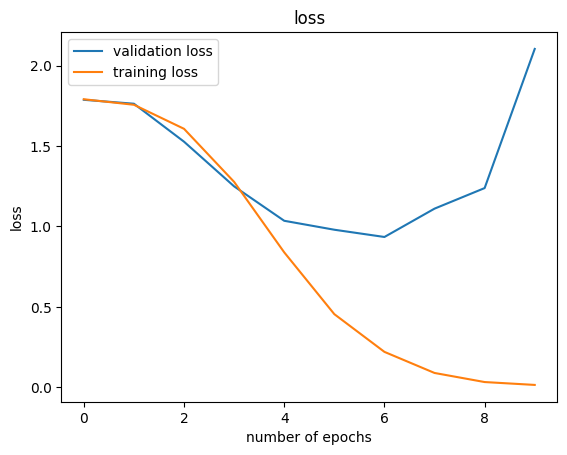

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.45s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


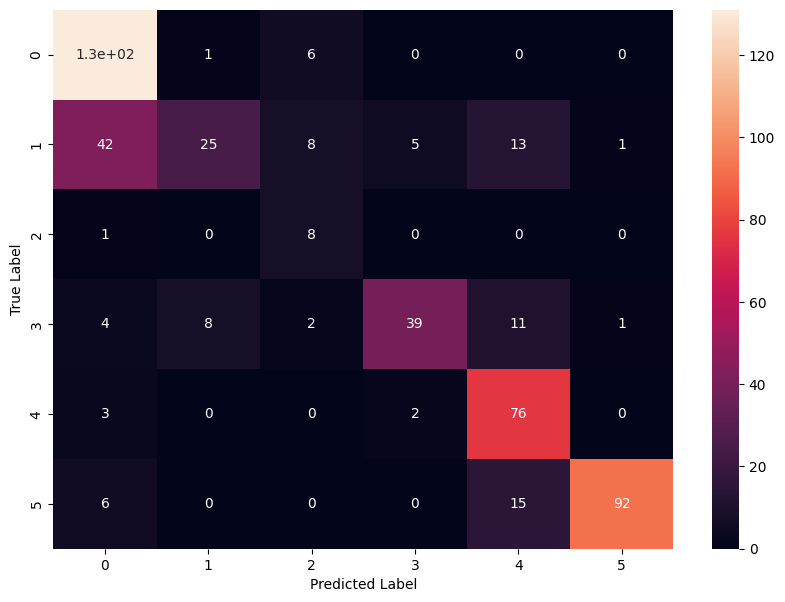

Accuracy: 0.742
Recall: [0.94927536 0.26595745 0.88888889 0.6        0.9382716  0.81415929]
Precision: [0.70053476 0.73529412 0.33333333 0.84782609 0.66086957 0.9787234 ]
F1_score: [0.80615385 0.390625   0.48484848 0.7027027  0.7755102  0.88888889]
gpt2.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                                      sentence
25830      5                How old was Martin Luther King
25831      5                       How old was the Titanic
25832      5    How old was the first man to walk on Earth
25833      5           How old was the first Black Panther
25834      5                  How old was the Queen Mother
25835      5  How old was Thelma Stone when she gave birth,        label                                           sentence
25854      5                        How many events

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.804935   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.798402   |      12.5      |     -      |     -     |     -    
   1    |    2    |   1.796119   |    17.1875     |     -      |     -     |     -    
   1    |    3    |   1.795419   |      12.5      |     -      |     -     |     -    
   1    |    4    |   1.795763   |      12.5      |     -      |     -     |     -    
   1    |    5    |   1.794692   |     21.875     |     -      |     -     |     -    
   1    |    6    |   1.794259   |    19.4444     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.794259   |    15.0546     |  1.776924  |   25.00   |  121.79  
------------------------

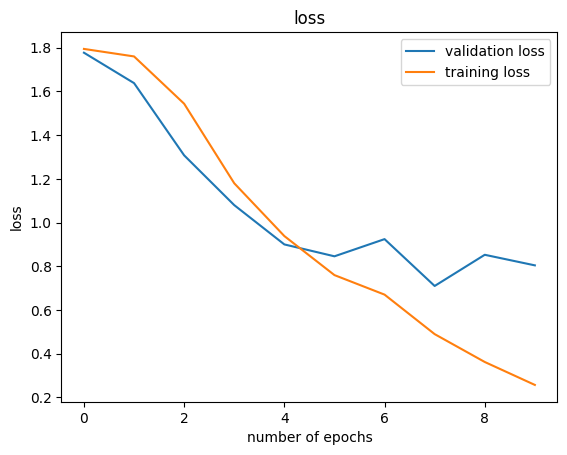

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:20<00:00,  2.56s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


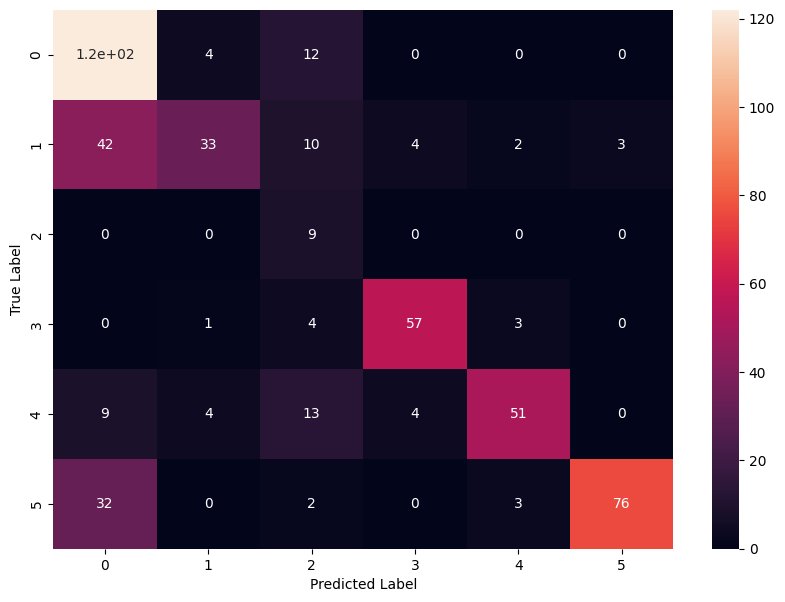

Accuracy: 0.696
Recall: [0.88405797 0.35106383 1.         0.87692308 0.62962963 0.67256637]
Precision: [0.59512195 0.78571429 0.18       0.87692308 0.86440678 0.96202532]
F1_score: [0.71137026 0.48529412 0.30508475 0.87692308 0.72857143 0.79166667]
cposgpt2.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                             sentence
25830      5  How old was Gene Wilder a member of
25831      5             How old was Gene Wilding
25832      5              How old was Gene Wilder
25833      5              How old was Gene Siskel
25834      5              How old was Gene Siskel
25835      5              How old was Gene Siskel,        label                                           sentence
25854      5    How many events make up three minutes in a year
25855      5  How many events make up a major 

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.804715   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.798123   |     15.625     |     -      |     -     |     -    
   1    |    2    |   1.794650   |    20.3125     |     -      |     -     |     -    
   1    |    3    |   1.794215   |     18.75      |     -      |     -     |     -    
   1    |    4    |   1.794114   |    14.0625     |     -      |     -     |     -    
   1    |    5    |   1.793190   |    17.1875     |     -      |     -     |     -    
   1    |    6    |   1.791392   |      25.0      |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791392   |    17.1875     |  1.790512  |   11.67   |  128.21  
------------------------

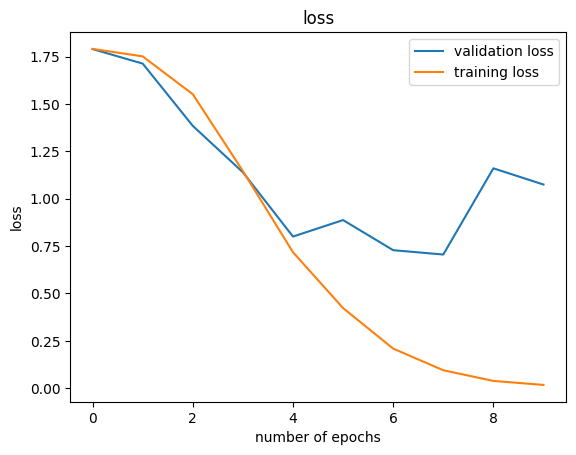

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.46s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


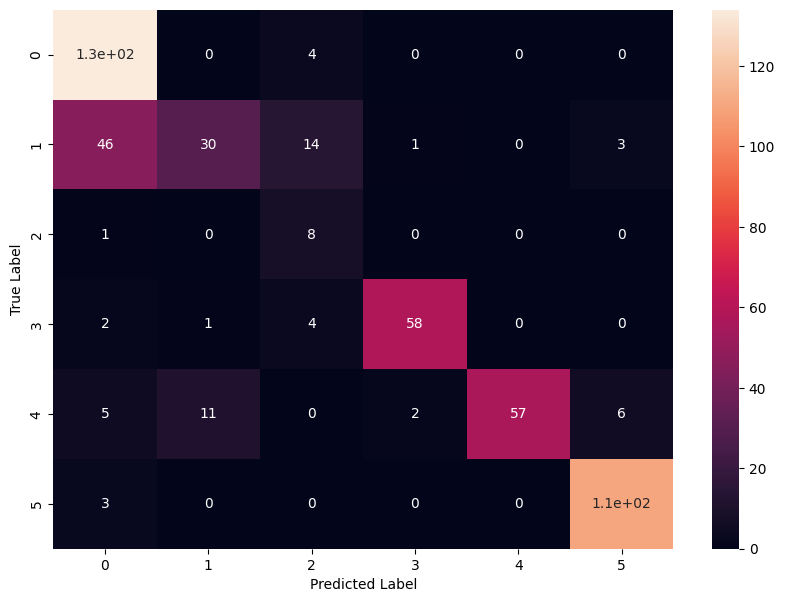

Accuracy: 0.794
Recall: [0.97101449 0.31914894 0.88888889 0.89230769 0.7037037  0.97345133]
Precision: [0.70157068 0.71428571 0.26666667 0.95081967 1.         0.92436975]
F1_score: [0.81458967 0.44117647 0.41025641 0.92063492 0.82608696 0.94827586]
gpt2_eda.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                                           sentence
25830      5                            how old was shea gehrig
25831      5      how old was the first human to get into space
25832      5  how sometime was alexander americas martyn lou...
25833      5  how onetime was the resolute john hoover first...
25834      5  how older was the cecil american army general ...
25835      5                  how honest to goodness is mckenna,        label                                           sentence
25854      5

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.797361   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.789317   |     21.875     |     -      |     -     |     -    
   1    |    2    |   1.793831   |     15.625     |     -      |     -     |     -    
   1    |    3    |   1.795732   |    10.9375     |     -      |     -     |     -    
   1    |    4    |   1.793252   |     15.625     |     -      |     -     |     -    
   1    |    5    |   1.793072   |    14.0625     |     -      |     -     |     -    
   1    |    6    |   1.791896   |      25.0      |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791896   |    16.0714     |  1.797553  |   16.67   |  119.41  
------------------------

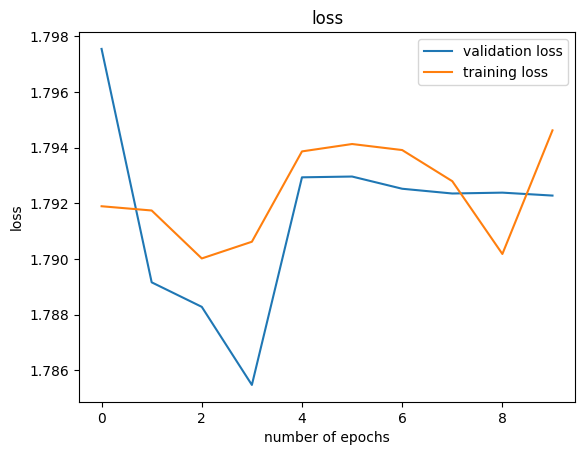

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:20<00:00,  2.56s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


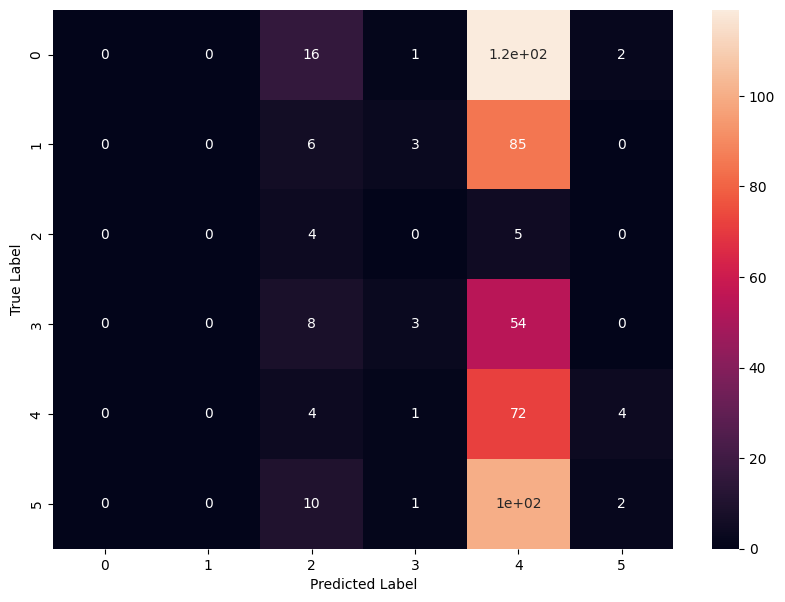

Accuracy: 0.162
Recall: [0.         0.         0.44444444 0.04615385 0.88888889 0.01769912]
Precision: [0.         0.         0.08333333 0.33333333 0.16551724 0.25      ]
F1_score: [0.         0.         0.14035088 0.08108108 0.27906977 0.03305785]
posgpt2_eda.tsv
                                     sentence  label
4305                How old was Gene Siskel ?      5
4309  How many events make up the decathlon ?      5
470        What is the wingspan of a condor ?      5
[       label                                           sentence
25830      5                         how old was cistron siskel
25831      5                 how old was factor 3 s first child
25832      5  how sometime was gene therapy introduced to th...
25833      5  how onetime was it for your average american t...
25834      5                how older are you from my dear lady
25835      5  how honest to goodness was gene the great whit...,        label                                           sentence
25854    

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.806044   |     9.375      |     -      |     -     |     -    
   1    |    1    |   1.796023   |    26.5625     |     -      |     -     |     -    
   1    |    2    |   1.795829   |    14.0625     |     -      |     -     |     -    
   1    |    3    |   1.794749   |    17.1875     |     -      |     -     |     -    
   1    |    4    |   1.795558   |      12.5      |     -      |     -     |     -    
   1    |    5    |   1.794831   |    14.0625     |     -      |     -     |     -    
   1    |    6    |   1.793989   |    13.8889     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.793989   |     15.377     |  1.798523  |   16.67   |  134.38  
------------------------

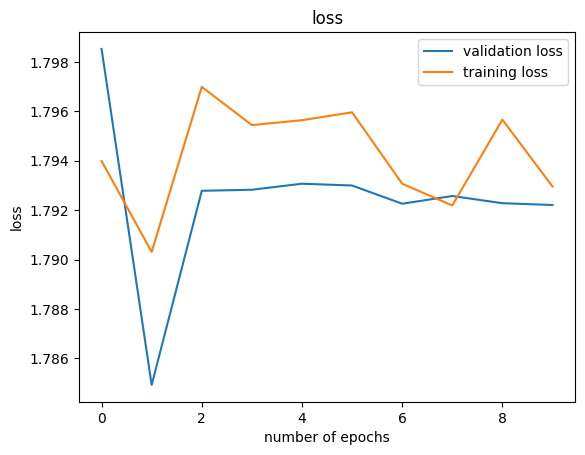

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:21<00:00,  2.67s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


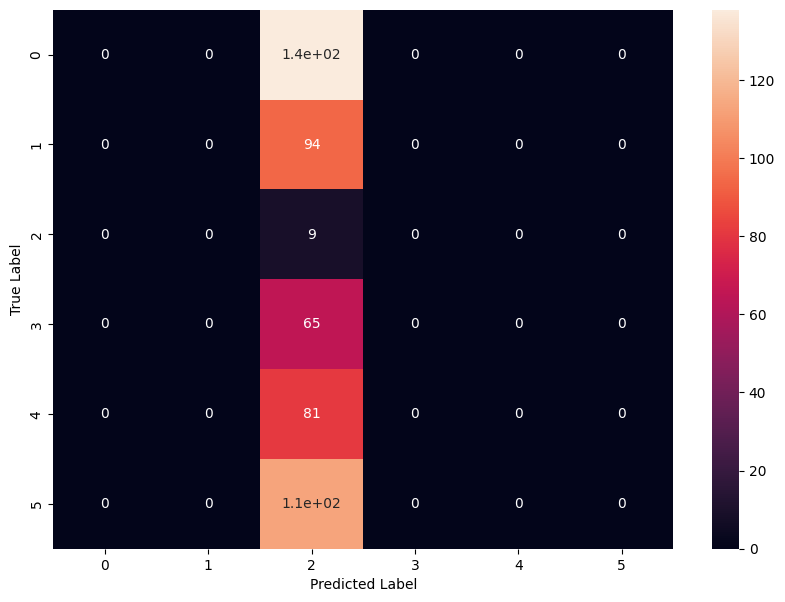

Accuracy: 0.018
Recall: [0. 0. 1. 0. 0. 0.]
Precision: [0.    0.    0.018 0.    0.    0.   ]
F1_score: [0.         0.         0.03536346 0.         0.         0.        ]
eda.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  how many citizenry lived in nebraska in the mid s
10603      5  how many citizenry lived in nebraska in the mid s
10604      5  how many multitude lived in nebraska in the mid s
10605      5  how many people populate in nebraska in the mid s
10606      5     how many masses lived in nebraska in the mid s
10607      5  how many multitude lived in nebraska in the mid s,       label                        sentence
8538      5  when did world war i get going
8539      5   when did world wa

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.791560   |     18.75      |     -      |     -     |     -    
   1    |    1    |   1.795397   |    17.1875     |     -      |     -     |     -    
   1    |    2    |   1.795668   |    14.0625     |     -      |     -     |     -    
   1    |    3    |   1.794785   |     15.625     |     -      |     -     |     -    
   1    |    4    |   1.793158   |    23.4375     |     -      |     -     |     -    
   1    |    5    |   1.792226   |      12.5      |     -      |     -     |     -    
   1    |    6    |   1.791244   |    22.2222     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791244   |    17.6835     |  1.760099  |   30.00   |  124.95  
------------------------

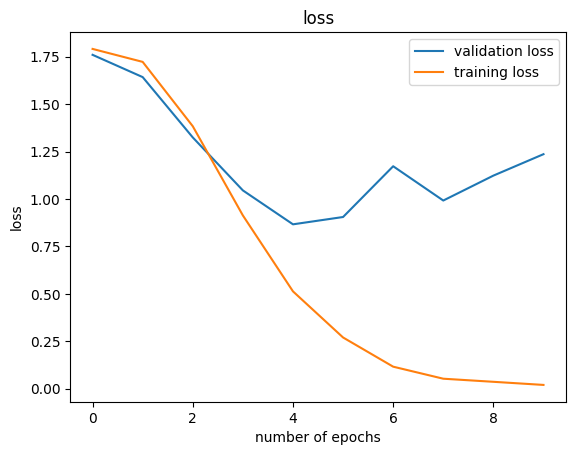

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.41s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


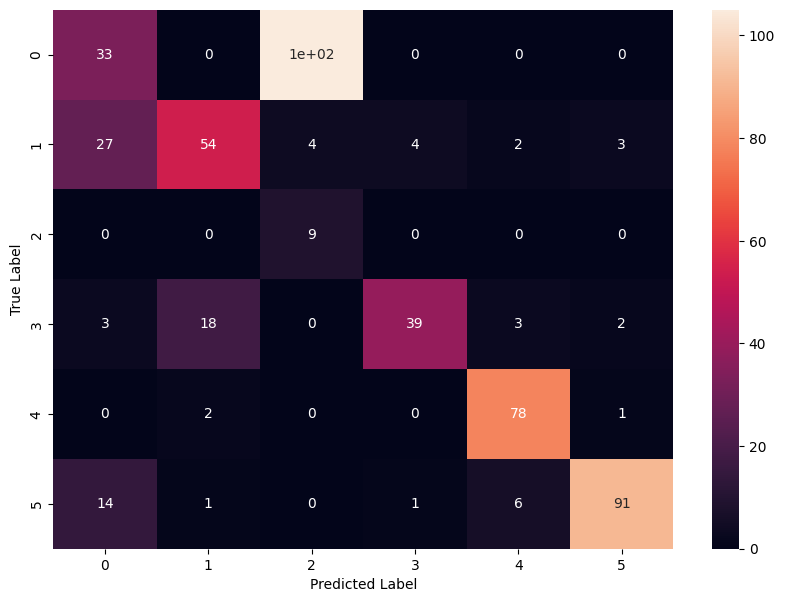

Accuracy: 0.608
Recall: [0.23913043 0.57446809 1.         0.6        0.96296296 0.80530973]
Precision: [0.42857143 0.72       0.07627119 0.88636364 0.87640449 0.93814433]
F1_score: [0.30697674 0.63905325 0.14173228 0.71559633 0.91764706 0.86666667]
backtranslate.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  How many people lived in Nebraska in the mid-1...
10603      5  How many people lived in Nebraska in the mid-1...
10604      5  How many people lived in Nebraska in the middl...
10605      5  How many people lived in Nebraska in the mid-1...
10606      5  How many people lived in Nebraska in the mid-1...
10607      5  How many people lived in Nebraska in the mid-1...,       label                    

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.795362   |    17.1875     |     -      |     -     |     -    
   1    |    1    |   1.797202   |     7.8125     |     -      |     -     |     -    
   1    |    2    |   1.794463   |      12.5      |     -      |     -     |     -    
   1    |    3    |   1.794021   |      12.5      |     -      |     -     |     -    
   1    |    4    |   1.793189   |    17.1875     |     -      |     -     |     -    
   1    |    5    |   1.792535   |    26.5625     |     -      |     -     |     -    
   1    |    6    |   1.791353   |    27.7778     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791353   |    17.3611     |  1.787146  |   31.67   |  117.07  
------------------------

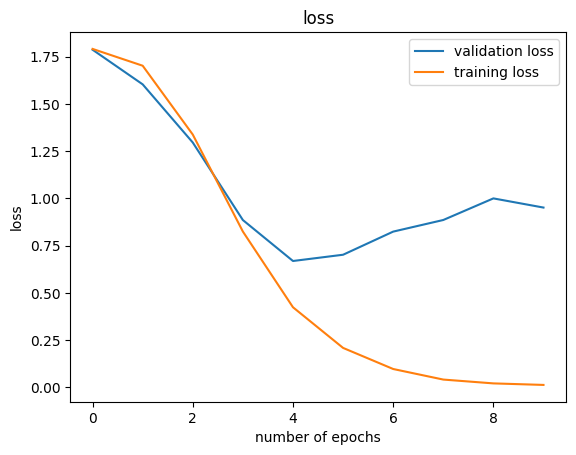

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.46s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


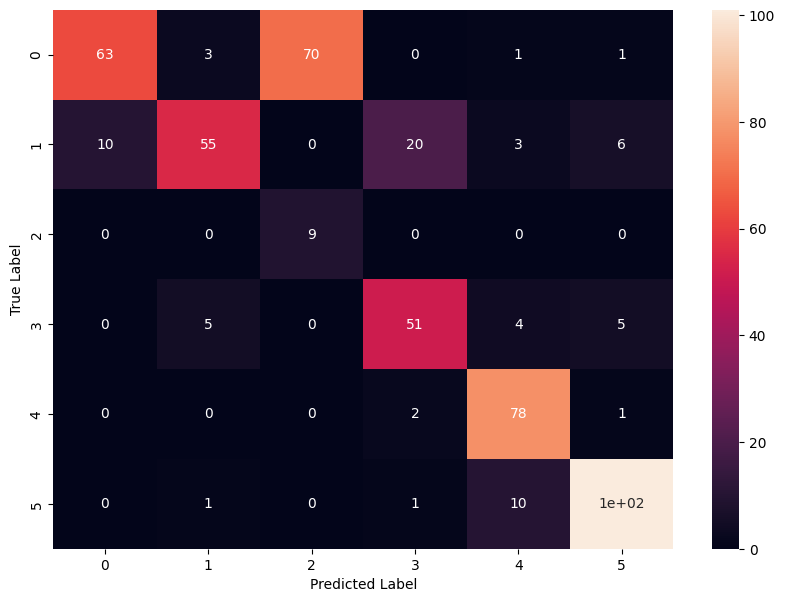

Accuracy: 0.714
Recall: [0.45652174 0.58510638 1.         0.78461538 0.96296296 0.89380531]
Precision: [0.8630137  0.859375   0.11392405 0.68918919 0.8125     0.88596491]
F1_score: [0.5971564  0.69620253 0.20454545 0.73381295 0.88135593 0.88986784]
cbert.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  how many people lived in nebraska in the mid 1...
10603      5  how many people lived in nebraska in the mid 1...
10604      5  how many people lived in nebraska in the mid 1...
10605      5  how many people lived in nebraska in the mid 1...
10606      5  how many people lived in nebraska in the mid 1...
10607      5  how many people lived in nebraska in the mid 1...,       label                      senten

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.795339   |    17.1875     |     -      |     -     |     -    
   1    |    1    |   1.797863   |     9.375      |     -      |     -     |     -    
   1    |    2    |   1.795029   |     18.75      |     -      |     -     |     -    
   1    |    3    |   1.794187   |     9.375      |     -      |     -     |     -    
   1    |    4    |   1.793069   |      12.5      |     -      |     -     |     -    
   1    |    5    |   1.792214   |    20.3125     |     -      |     -     |     -    
   1    |    6    |   1.790596   |      25.0      |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.790596   |    16.0714     |  1.781618  |   23.33   |  113.73  
------------------------

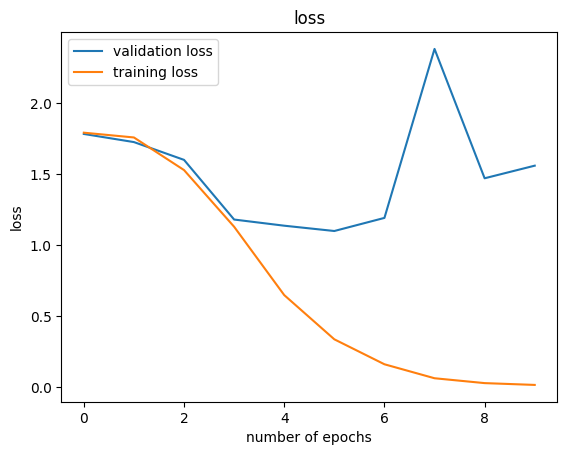

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:18<00:00,  2.35s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


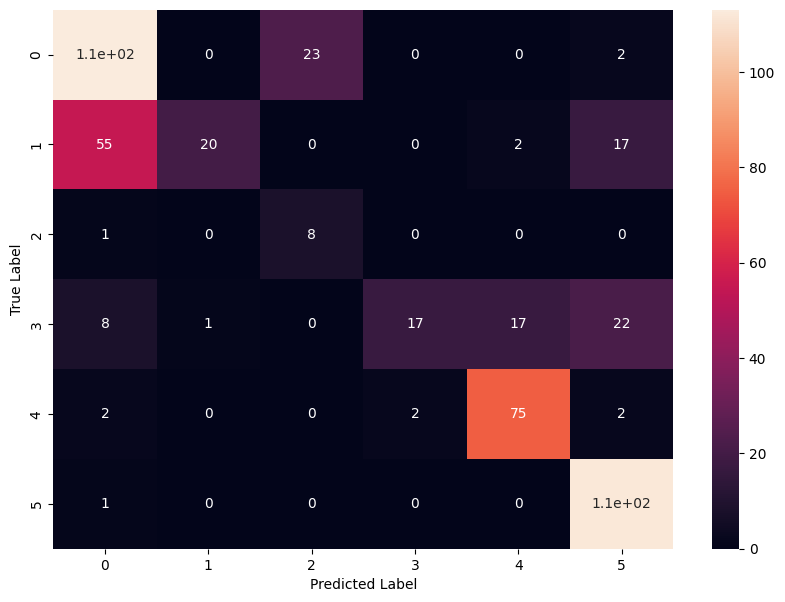

Accuracy: 0.69
Recall: [0.81884058 0.21276596 0.88888889 0.26153846 0.92592593 0.99115044]
Precision: [0.62777778 0.95238095 0.25806452 0.89473684 0.79787234 0.72258065]
F1_score: [0.71069182 0.34782609 0.4        0.4047619  0.85714286 0.8358209 ]
gpt2.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  How many people were killed in Operation Iraqi...
10603      5                      How many people live in the U
10604      5         How many people was there when U2 was born
10605      5        How many people died during the Vietnam War
10606      5  How many people died of tuberculosis in the 1930s
10607      5  How many people died as a result of the Vietna...,       label                              

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.792907   |     18.75      |     -      |     -     |     -    
   1    |    1    |   1.791141   |     18.75      |     -      |     -     |     -    
   1    |    2    |   1.790966   |    14.0625     |     -      |     -     |     -    
   1    |    3    |   1.792440   |      12.5      |     -      |     -     |     -    
   1    |    4    |   1.792527   |     15.625     |     -      |     -     |     -    
   1    |    5    |   1.792604   |    26.5625     |     -      |     -     |     -    
   1    |    6    |   1.792294   |    22.2222     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.792294   |    18.3532     |  1.789348  |   16.67   |  124.81  
------------------------

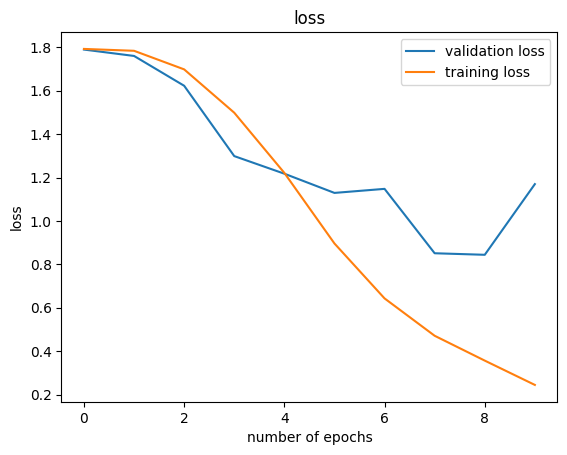

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:20<00:00,  2.59s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


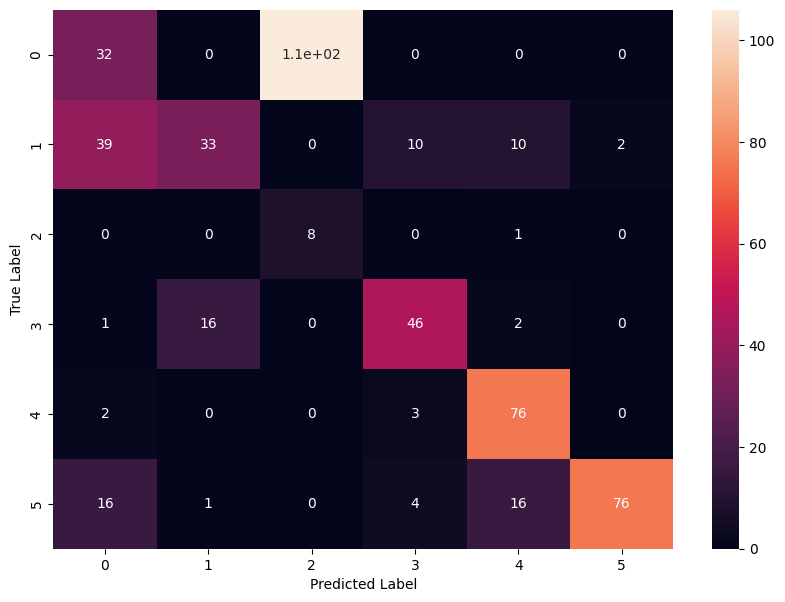

Accuracy: 0.542
Recall: [0.23188406 0.35106383 0.88888889 0.70769231 0.9382716  0.67256637]
Precision: [0.35555556 0.66       0.07017544 0.73015873 0.72380952 0.97435897]
F1_score: [0.28070175 0.45833333 0.1300813  0.71875    0.8172043  0.79581152]
cposgpt2.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  How many people lived in Berlin on August 1, 1939
10603      5  How many people lived in the San Diego area du...
10604      5                  How many people lived in Nebraska
10605      5       How many people lived in Nebraska after 1948
10606      5  How many people lived in Nebraska in the mid-1...
10607      5  How many people lived in Nebraska in the mid 2...,       label                     sent

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.796225   |     15.625     |     -      |     -     |     -    
   1    |    1    |   1.796627   |      6.25      |     -      |     -     |     -    
   1    |    2    |   1.794237   |    23.4375     |     -      |     -     |     -    
   1    |    3    |   1.793261   |    17.1875     |     -      |     -     |     -    
   1    |    4    |   1.792596   |     21.875     |     -      |     -     |     -    
   1    |    5    |   1.792577   |     21.875     |     -      |     -     |     -    
   1    |    6    |   1.791760   |      25.0      |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791760   |     18.75      |  1.787377  |   25.00   |  115.80  
------------------------

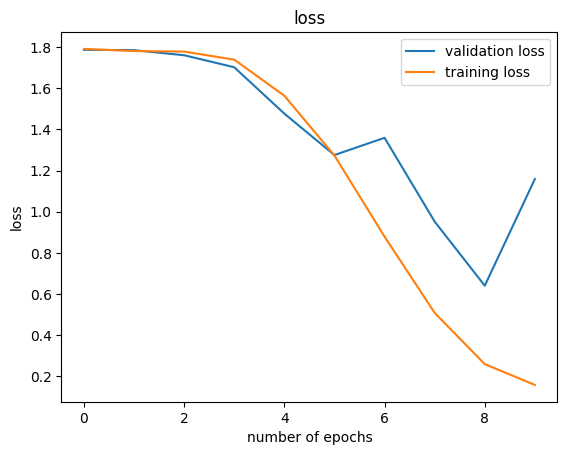

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:20<00:00,  2.51s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


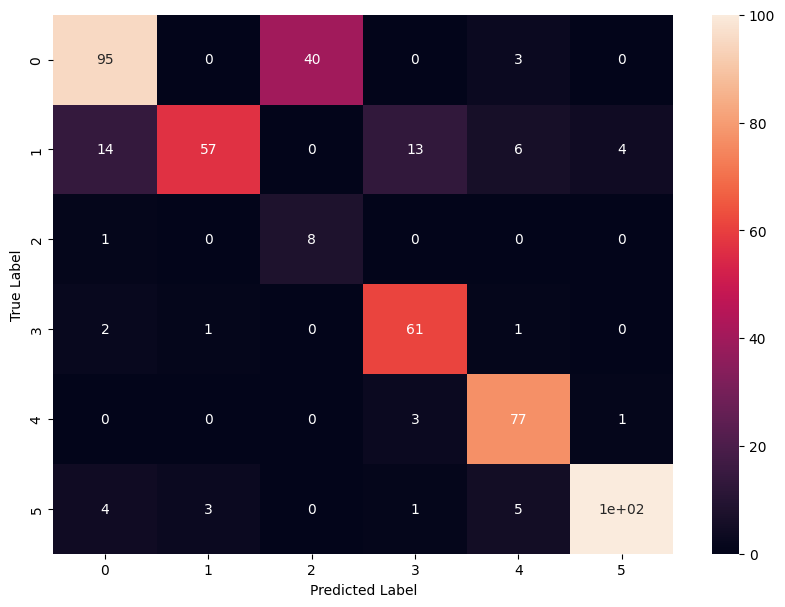

Accuracy: 0.796
Recall: [0.6884058  0.60638298 0.88888889 0.93846154 0.95061728 0.88495575]
Precision: [0.81896552 0.93442623 0.16666667 0.78205128 0.83695652 0.95238095]
F1_score: [0.7480315  0.73548387 0.28070175 0.85314685 0.89017341 0.91743119]
gpt2_eda.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5                  how many citizenry does rick have
10603      5  how many citizenry did the american navy estab...
10604      5     how many multitude of stars have the name nana
10605      5            how many people died in the vietnam war
10606      5           how many masses are in a city each month
10607      5          how many multitude are there in the world,       label                         

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.794252   |     15.625     |     -      |     -     |     -    
   1    |    1    |   1.794742   |    10.9375     |     -      |     -     |     -    
   1    |    2    |   1.794911   |    10.9375     |     -      |     -     |     -    
   1    |    3    |   1.792920   |      25.0      |     -      |     -     |     -    
   1    |    4    |   1.790755   |    20.3125     |     -      |     -     |     -    
   1    |    5    |   1.791132   |     15.625     |     -      |     -     |     -    
   1    |    6    |   1.791136   |    16.6667     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791136   |    16.4435     |  1.784249  |   25.00   |  137.56  
------------------------

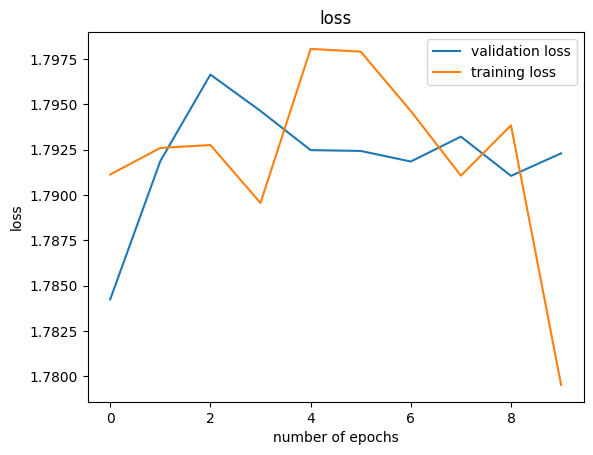

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:21<00:00,  2.70s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


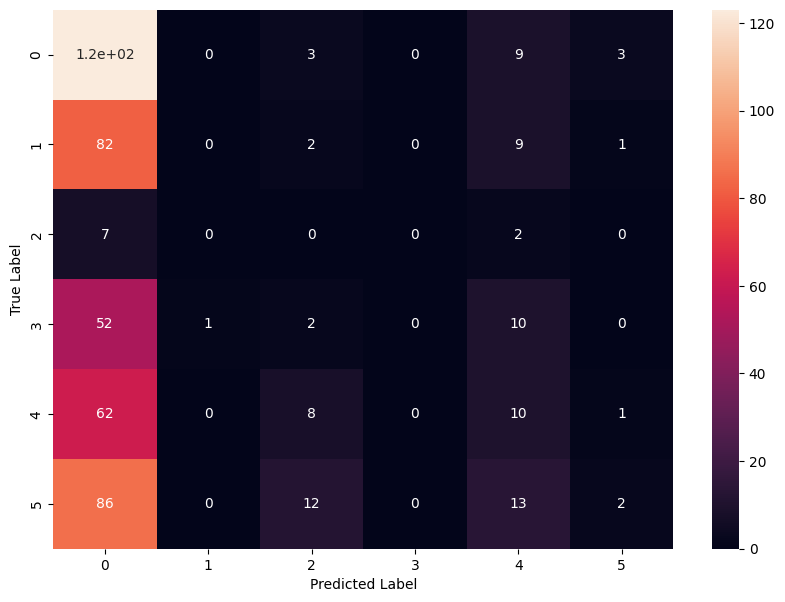

Accuracy: 0.27
Recall: [0.89130435 0.         0.         0.         0.12345679 0.01769912]
Precision: [0.29854369 0.         0.         0.         0.18867925 0.28571429]
F1_score: [0.44727273 0.         0.         0.         0.14925373 0.03333333]
posgpt2_eda.tsv
                                               sentence  label
1767  How many people lived in Nebraska in the mid 1...      5
1423                       When did World War I start ?      5
2888         How many frames does a disk camera shoot ?      5
[       label                                           sentence
10602      5  how many citizenry have died from carbicide be...
10603      5  how many citizenry lived in ernie ville s cath...
10604      5  how many multitude lived at a given site in th...
10605      5   how many people populate in nebraska in the year
10606      5     how many masses lived in nebraska in the mid s
10607      5      how many multitude lived in nebraska in the s,       label                       

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.792921   |     18.75      |     -      |     -     |     -    
   1    |    1    |   1.794722   |    10.9375     |     -      |     -     |     -    
   1    |    2    |   1.791193   |     15.625     |     -      |     -     |     -    
   1    |    3    |   1.791386   |      12.5      |     -      |     -     |     -    
   1    |    4    |   1.792093   |    14.0625     |     -      |     -     |     -    
   1    |    5    |   1.791280   |    20.3125     |     -      |     -     |     -    
   1    |    6    |   1.792206   |    19.4444     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.792206   |    15.9474     |  1.790607  |   16.67   |  136.58  
------------------------

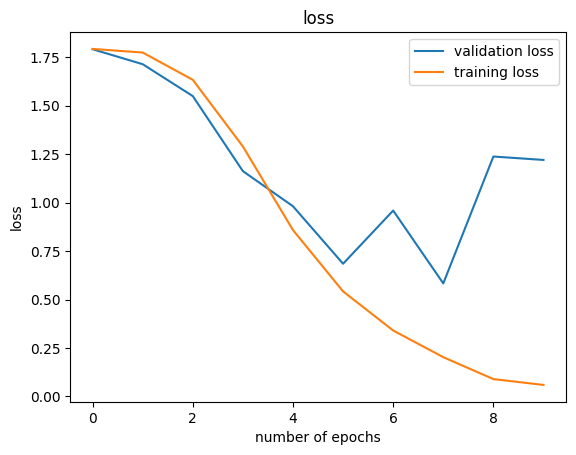

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:22<00:00,  2.83s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


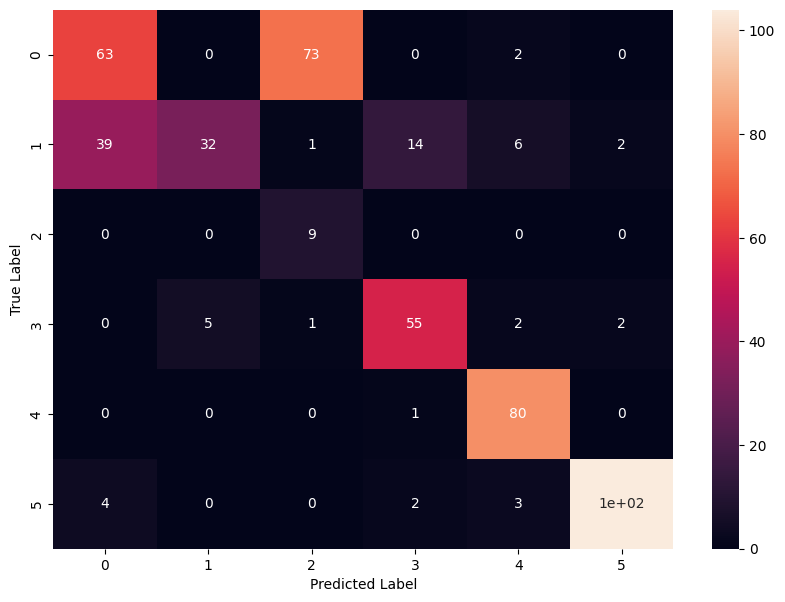

Accuracy: 0.686
Recall: [0.45652174 0.34042553 1.         0.84615385 0.98765432 0.92035398]
Precision: [0.59433962 0.86486486 0.10714286 0.76388889 0.86021505 0.96296296]
F1_score: [0.51639344 0.48854962 0.19354839 0.80291971 0.91954023 0.94117647]
eda.tsv
                                               sentence  label
1270                      How far out is the universe ?      5
1974  What percent liked Thatcher after she had been...      5
2025            What is the average age a horse lives ?      5
[      label                                           sentence
7620      5                       how alir out is the universe
7621      5                       how far out is the macrocosm
7622      5  how army for the liberation of rwanda out is t...
7623      5                how interahamwe out is the universe
7624      5                       how alir out is the universe
7625      5                       how far out is the existence,        label                                    

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.794960   |    20.3125     |     -      |     -     |     -    
   1    |    1    |   1.795128   |    17.1875     |     -      |     -     |     -    
   1    |    2    |   1.792544   |     18.75      |     -      |     -     |     -    
   1    |    3    |   1.792038   |     15.625     |     -      |     -     |     -    
   1    |    4    |   1.793306   |    14.0625     |     -      |     -     |     -    
   1    |    5    |   1.793605   |      12.5      |     -      |     -     |     -    
   1    |    6    |   1.790123   |    16.6667     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.790123   |    16.4435     |  1.781104  |   18.33   |  684.53  
------------------------

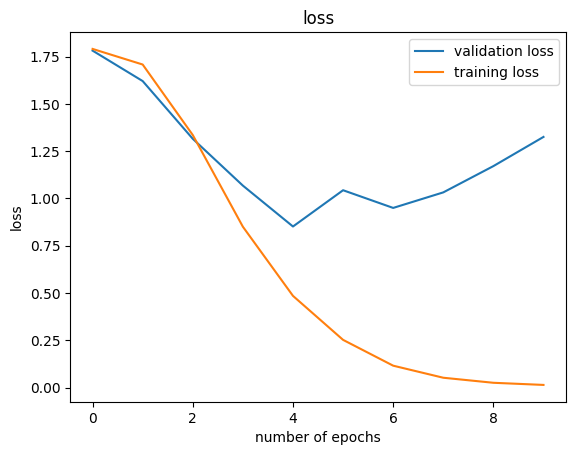

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [05:02<00:00, 37.80s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


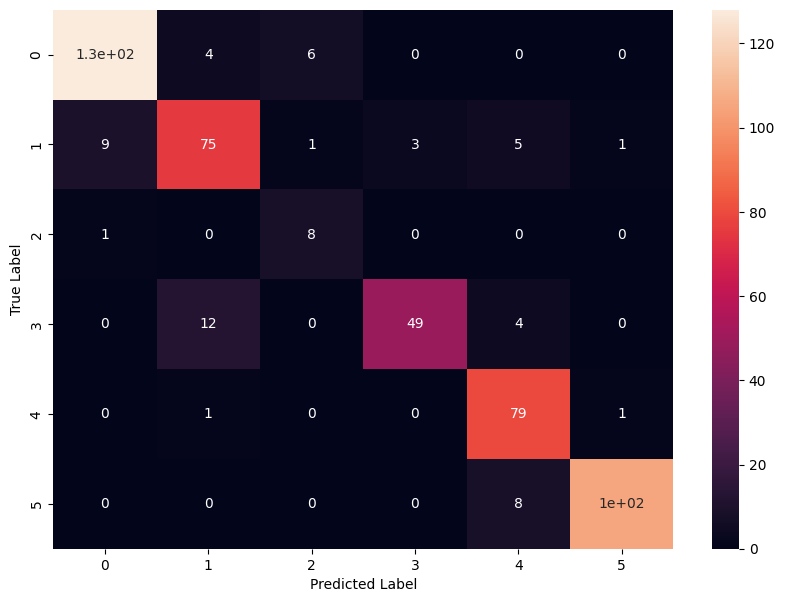

Accuracy: 0.888
Recall: [0.92753623 0.79787234 0.88888889 0.75384615 0.97530864 0.92920354]
Precision: [0.92753623 0.81521739 0.53333333 0.94230769 0.82291667 0.98130841]
F1_score: [0.92753623 0.80645161 0.66666667 0.83760684 0.89265537 0.95454545]
backtranslate.tsv
                                               sentence  label
1270                      How far out is the universe ?      5
1974  What percent liked Thatcher after she had been...      5
2025            What is the average age a horse lives ?      5
[      label                  sentence
7620      5  How far is the universe?
7621      5  How far is the universe?
7622      5  How far is the universe?
7623      5  How far is the universe?
7624      5  How far is the universe?
7625      5     When is the universe?,        label                                           sentence
11844      5  What percentage did Thatcher like after she wa...
11845      5  What percentage did Thatcher like after she ha...
11846      5  What pe

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.790301   |     21.875     |     -      |     -     |     -    
   1    |    1    |   1.795813   |    14.0625     |     -      |     -     |     -    
   1    |    2    |   1.799259   |     4.6875     |     -      |     -     |     -    
   1    |    3    |   1.796021   |     28.125     |     -      |     -     |     -    
   1    |    4    |   1.794748   |     15.625     |     -      |     -     |     -    
   1    |    5    |   1.794440   |    14.0625     |     -      |     -     |     -    
   1    |    6    |   1.793504   |    16.6667     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.793504   |    16.4435     |  1.792435  |   16.67   |  675.81  
------------------------

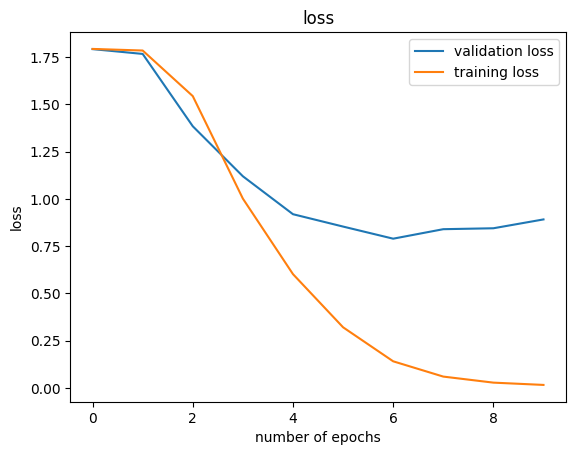

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [05:02<00:00, 37.81s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


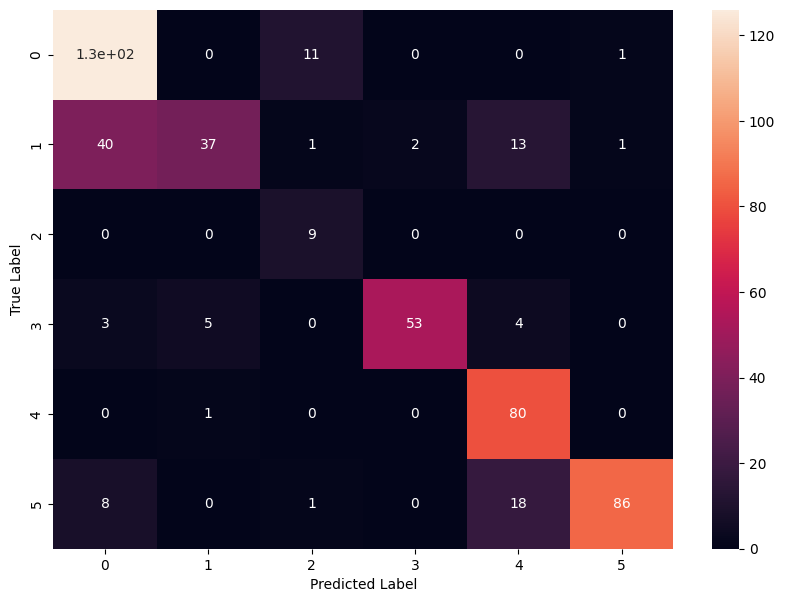

Accuracy: 0.782
Recall: [0.91304348 0.39361702 1.         0.81538462 0.98765432 0.76106195]
Precision: [0.71186441 0.86046512 0.40909091 0.96363636 0.69565217 0.97727273]
F1_score: [0.8        0.54014599 0.58064516 0.88333333 0.81632653 0.85572139]
cbert.tsv
                                               sentence  label
1270                      How far out is the universe ?      5
1974  What percent liked Thatcher after she had been...      5
2025            What is the average age a horse lives ?      5
[      label                   sentence
7620      5     how far out is the sun
7621      5  how far out is the thames
7622      5     how far out is the sun
7623      5   how far out is the ocean
7624      5     how far out is the sun
7625      5     how far out is the sun,        label                                           sentence
11844      5  what percent liked thatcher after she had been...
11845      5  what percent liked thatcher after she had been...
11846      5  what per

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.789753   |    20.3125     |     -      |     -     |     -    
   1    |    1    |   1.795110   |    14.0625     |     -      |     -     |     -    
   1    |    2    |   1.798459   |     4.6875     |     -      |     -     |     -    
   1    |    3    |   1.795122   |     28.125     |     -      |     -     |     -    
   1    |    4    |   1.793475   |     15.625     |     -      |     -     |     -    
   1    |    5    |   1.792599   |     15.625     |     -      |     -     |     -    
   1    |    6    |   1.791519   |    16.6667     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791519   |    16.4435     |  1.788921  |   16.67   |  690.23  
------------------------

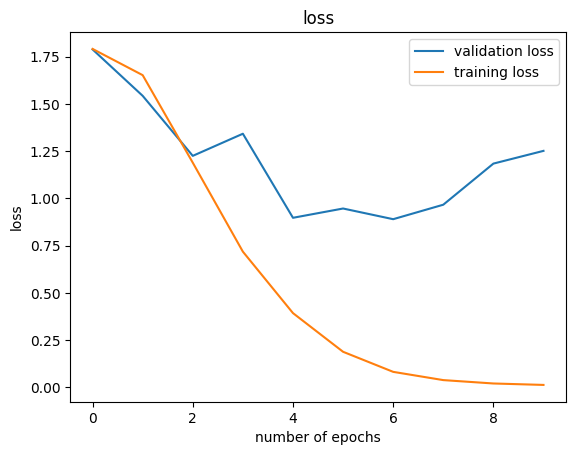

Training complete!


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|█████████████████████████████████████████████| 8/8 [00:29<00:00,  3.74s/it]
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


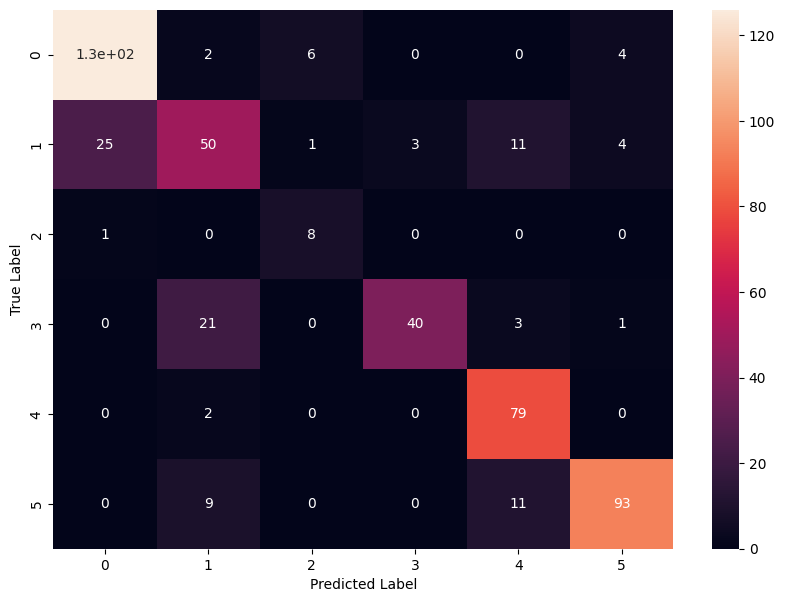

Accuracy: 0.792
Recall: [0.91304348 0.53191489 0.88888889 0.61538462 0.97530864 0.82300885]
Precision: [0.82894737 0.5952381  0.53333333 0.93023256 0.75961538 0.91176471]
F1_score: [0.86896552 0.56179775 0.66666667 0.74074074 0.85405405 0.86511628]
gpt2.tsv
                                               sentence  label
1270                      How far out is the universe ?      5
1974  What percent liked Thatcher after she had been...      5
2025            What is the average age a horse lives ?      5
[      label                                           sentence
7620      5  How far out of the Arctic do you need to be to...
7621      5                          How far out is the Arctic
7622      5               How far out does a black hole travel
7623      5                How far out is the Milky Way galaxy
7624      5                    How far out does sea level rise
7625      5  How far out of the Arctic does the Arctic ocea...,        label                                   

/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Cellar/jupyterlab/4.0.6_1/libexec/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementati

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Accuracy |  Val Loss  |  Val Acc  |  Elapsed 
--------------------------------------------------------------------------------------
   1    |    0    |   1.788495   |     21.875     |     -      |     -     |     -    
   1    |    1    |   1.793885   |    14.0625     |     -      |     -     |     -    
   1    |    2    |   1.797059   |      6.25      |     -      |     -     |     -    
   1    |    3    |   1.795160   |    26.5625     |     -      |     -     |     -    
   1    |    4    |   1.793851   |    17.1875     |     -      |     -     |     -    
   1    |    5    |   1.793345   |    10.9375     |     -      |     -     |     -    
   1    |    6    |   1.791824   |    27.7778     |     -      |     -     |     -    
--------------------------------------------------------------------------------------
  end   |    -    |   1.791824   |    17.8075     |  1.780468  |   25.00   |  377.98  
------------------------

In [ ]:
# from sklearn.metrics import accuracy_score
runtimes = 5
hidden = 512
seeds = []
for i in range(runtimes):
    seeds.append(random.randint(0,100))


b = {'val_loss':[], 'val_accuracy':[],'test_accuracy':[],'dis':[],'kl':[],'k_acc':[]}

qbm = {'val_loss':[], 'val_accuracy':[],'test_accuracy':[],'dis':[],'kl':[],'k_acc':[]}

sb = {'val_loss':[], 'val_accuracy':[],'test_accuracy':[],'dis':[],'kl':[],'k_acc':[]}

sqbm = {'val_loss':[], 'val_accuracy':[],'test_accuracy':[],'dis':[],'kl':[],'k_acc':[]}

outfile = 'trec_aug'
aug_paths = ['eda.tsv','backtranslate.tsv','cbert.tsv','gpt2.tsv','cposgpt2.tsv','gpt2_eda.tsv','posgpt2_eda.tsv']


for i in seeds:
    for aug_path in aug_paths:
        print(aug_path)
        train_dataloader, val_dataloader, test_dataloader = prepare_data(num_train, train_path, valid_path, test_path,\
                                                                         aug_path=f'{outfile}/{aug_path}',sample=10\
                                                                         , seed = i, tsv = tsv , all=False,aug=True)
        
        
        set_seed(i)
        epoch = 10
        patience=15
        scl = False
        Qbert_classifier_min, optimizer = initialize_model(QModel_Classifier,hidden=hidden,num_labels = num_classes,feature_remove_max = True)
        val_loss, val_accuracy = train(Qbert_classifier_min, train_dataloader, temprature, lam, scl, epoch , val_dataloader, evaluation=True,patience=patience)
        test_accuracy = test_evaluate(QModel_Classifier,cross_model_path, test_dataloader,hidden=hidden,num_labels=num_classes,feature_remove_max=True)

        qbm['val_loss'].append(val_loss)
        qbm['val_accuracy'].append(val_accuracy)
        qbm['test_accuracy'].append(test_accuracy)


In [ ]:
def mean_std(list):
    return np.average(list) , np.std(list)

In [ ]:
print(mean_std(b['val_loss']))

print(mean_std(qbm['val_loss']))

print(mean_std(sb['val_loss']))

print(mean_std(sqbm['val_loss']))

In [ ]:
print(mean_std(b['test_accuracy']))

print(mean_std(qbm['test_accuracy']))

print(mean_std(sb['test_accuracy']))

print(mean_std(sqbm['test_accuracy']))

In [ ]:
print(mean_std(b['dis']))

print(mean_std(qbm['dis']))

print(mean_std(sb['dis']))

print(mean_std(sqbm['dis']))

In [ ]:
original = 355359744

In [ ]:
nb_param_qm - original 

In [ ]:
nb_param_r - original

In [ ]:
num_classes

In [ ]:
## from transformers import RobertaModel
bert = RobertaModel.from_pretrained('roberta-large')
print("classifer Infos --------------------")
train_dataloader, val_dataloader, test_dataloader = prepare_data(num_train, train_path, valid_path, test_path,sample=10\
                                                                     , seed = 40, tsv = tsv , all=False)

hiddens = [16,32,64,128,256]
for hidden in hiddens :
    model = Model_Classifier(1024, hidden,num_labels = num_classes, dropout=0.1)
    Qmodel_min = QModel_Classifier(1024, hidden,num_labels = num_classes, dropout=0.1,feature_remove_max = True)
    original = sum(p.numel() for p in bert.parameters() if p.requires_grad)
    nb_param_r = sum(p.numel() for p in model.parameters() if p.requires_grad)
    nb_param_qm = sum(p.numel() for p in Qmodel_min.parameters() if p.requires_grad)
    
    print(f'hidden: {hidden}')
    print("(Transformer)  Number of trainable parameters : "+str(nb_param_r-original))
    print("(QTransformer_min)) Number of trainable parameters : "+str(nb_param_qm-original))
    print()